### **Transformer Implementation**
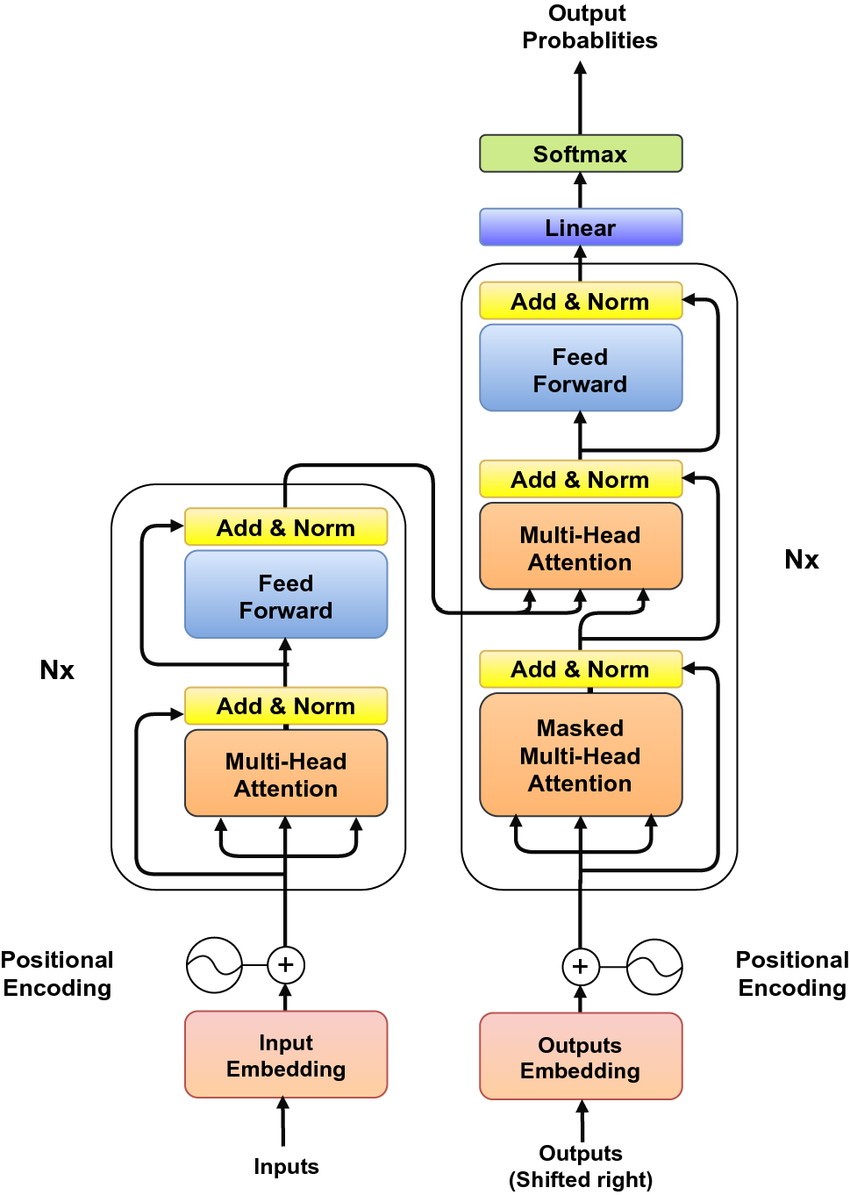

In [ ]:
from torch import nn
import torch
import math
from torch import nn, optim
from torch.optim import Adam

#### **1.1 Positional Encoding**

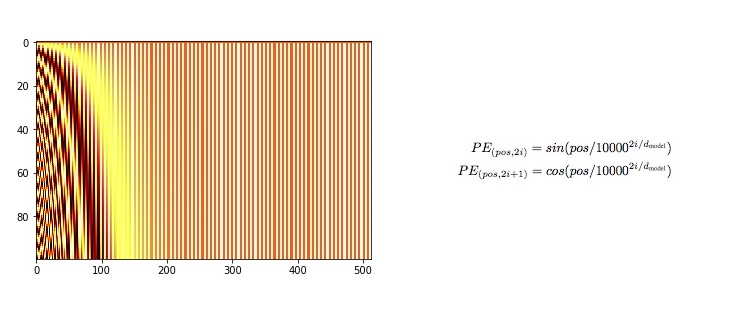


In [ ]:
class PositionalEncoding(nn.Module):
    """
    compute sinusoid encoding.
    """
    def __init__(self, d_model, max_len, device):
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient

        pos = torch.arange(0, max_len, device=device)
        pos = pos.float().unsqueeze(dim=1)
        # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]         

In [ ]:
class TransformerEmbedding(nn.Module):
    """
    token embedding + positional encoding (sinusoid)
    positional encoding can give positional information to network
    """
    def __init__(self, vocab_size, d_model, max_len, drop_prob, device):
        """
        class for word embedding that included positional information

        :param vocab_size: size of vocabulary
        :param d_model: dimensions of model
        """
        super(TransformerEmbedding, self).__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = PositionalEncoding(d_model, max_len, device)
        self.drop_out = nn.Dropout(p=drop_prob)

    def forward(self, x):
        tok_emb = self.tok_emb(x)
        pos_emb = self.pos_emb(x)
        return self.drop_out(tok_emb + pos_emb)

#### **1.2 Scale Dot Product Attention**

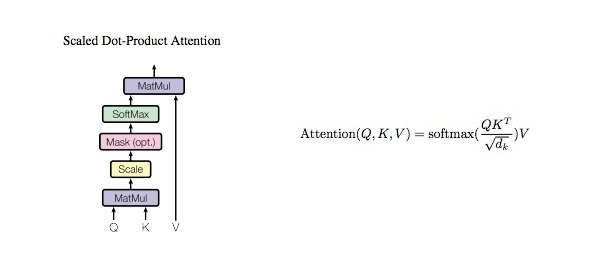

In [ ]:
class ScaleDotProductAttention(nn.Module):
    """
    compute scale dot product attention

    Query : given sentence that we focused on (decoder)
    Key : every sentence to check relationship with Qeury(encoder)
    Value : every sentence same with Key (encoder)
    """

    def __init__(self):
        super(ScaleDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None, e=1e-12):
        # input is 4 dimension tensor
        # [batch_size, head, length, d_tensor]
        batch_size, head, length, d_tensor = k.size()

        # 1. dot product Query with Key^T to compute similarity
        k_t = k.transpose(2, 3)  # transpose
        score = (q @ k_t) / math.sqrt(d_tensor)  # scaled dot product

        # 2. apply masking (opt)
        if mask is not None:
            score = score.masked_fill(mask == 0, -10000)

        # 3. pass them softmax to make [0, 1] range
        score = self.softmax(score)

        # 4. multiply with Value
        v = score @ v

        return v, score

#### **1.3 Multi-Head Attention**
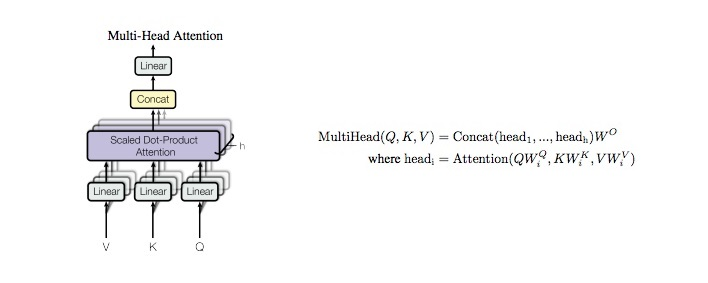

In [1]:
class MultiHeadAttention(nn.Module):
    
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.n_head = n_head
        self.attention = ScaleDotProductAttention()
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_concat = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        # 1. dot product with weight matrices
        q, k, v = self.w_q(q), self.w_k(k), self.w_v(v)

        # 2. split tensor by number of heads
        q, k, v = self.split(q), self.split(k), self.split(v)

        # 3. do scale dot product to compute similarity
        out, attention = self.attention(q, k, v, mask=mask)
        
        # 4. concat and pass to linear layer
        out = self.concat(out)
        out = self.w_concat(out)

        # 5. visualize attention map
        # TODO : we should implement visualization

        return out

    def split(self, tensor):
        """
        split tensor by number of head

        :param tensor: [batch_size, length, d_model]
        :return: [batch_size, head, length, d_tensor]
        """
        batch_size, length, d_model = tensor.size()

        d_tensor = d_model // self.n_head
        tensor = tensor.view(batch_size, length, self.n_head, d_tensor).transpose(1, 2)
        # it is similar with group convolution (split by number of heads)

        return tensor

    def concat(self, tensor):
        """
        inverse function of self.split(tensor : torch.Tensor)

        :param tensor: [batch_size, head, length, d_tensor]
        :return: [batch_size, length, d_model]
        """
        batch_size, head, length, d_tensor = tensor.size()
        d_model = head * d_tensor

        tensor = tensor.transpose(1, 2).contiguous().view(batch_size, length, d_model)
        return tensor

NameError: name 'nn' is not defined

#### **1.4 Positionwise Feed Forward**

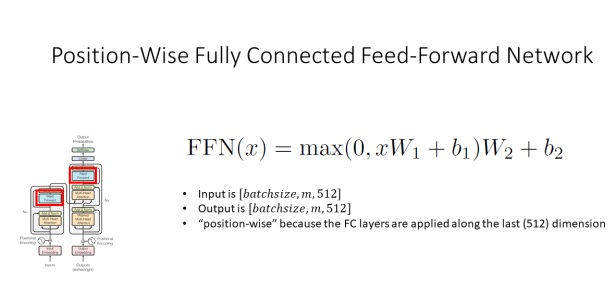

In [ ]:
class PositionwiseFeedForward(nn.Module):
    
    def __init__(self, d_model, hidden, drop_prob=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=drop_prob)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

#### **1.5 Layer Norm**
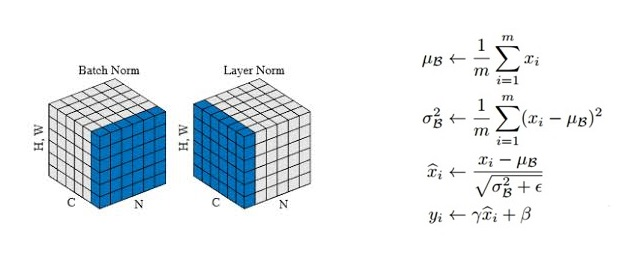

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_model, eps=1e-12):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(d_model))
        self.beta = nn.Parameter(torch.zeros(d_model))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)
        # '-1' means last dimension. 

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

#### **1.6 Encoder & Decoder Structure**
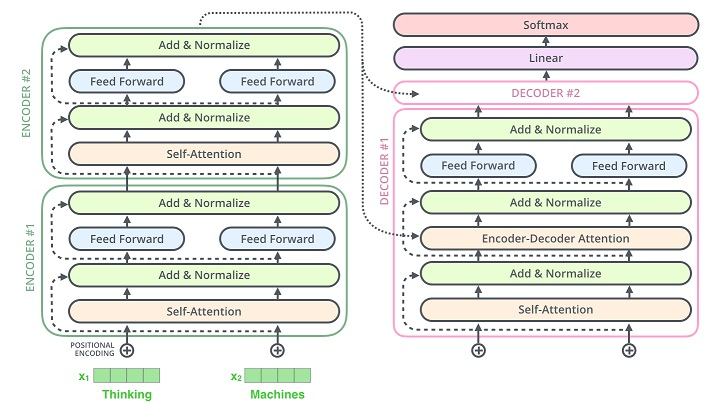

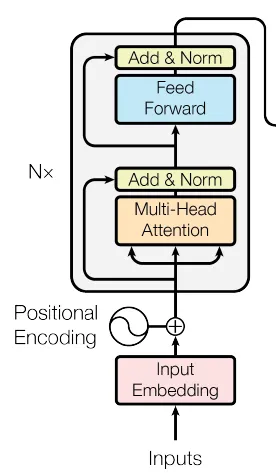

In [ ]:
class EncoderLayer(nn.Module):
    
    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

    def forward(self, x, src_mask):
        # 1. compute self attention
        _x = x
        x = self.attention(q=x, k=x, v=x, mask=src_mask)
        
        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)
        
        # 3. positionwise feed forward network
        _x = x
        x = self.ffn(x)
      
        # 4. add and norm
        x = self.dropout2(x)
        x = self.norm2(x + _x)
        return x

In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        max_len=max_len,
                                        vocab_size=enc_voc_size,
                                        drop_prob=drop_prob,
                                        device=device)

        self.layers = nn.ModuleList([EncoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

    def forward(self, x, src_mask):
        x = self.emb(x)

        for layer in self.layers:
            x = layer(x, src_mask)

        return x

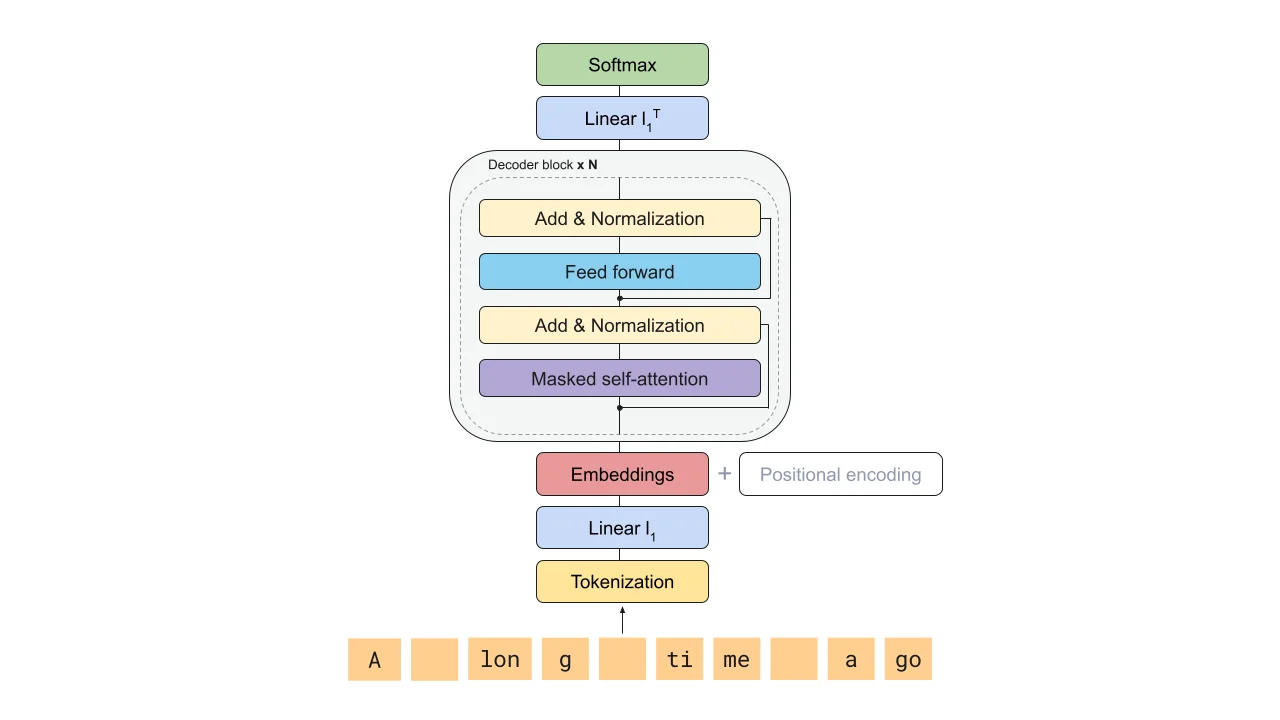

In [ ]:
class DecoderLayer(nn.Module):
    
    def __init__(self, d_model, ffn_hidden, n_head, drop_prob):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm1 = LayerNorm(d_model=d_model)
        self.dropout1 = nn.Dropout(p=drop_prob)

        self.enc_dec_attention = MultiHeadAttention(d_model=d_model, n_head=n_head)
        self.norm2 = LayerNorm(d_model=d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)

        self.ffn = PositionwiseFeedForward(d_model=d_model, hidden=ffn_hidden, drop_prob=drop_prob)
        self.norm3 = LayerNorm(d_model=d_model)
        self.dropout3 = nn.Dropout(p=drop_prob)

    def forward(self, dec, enc, trg_mask, src_mask):    
        # 1. compute self attention
        _x = dec
        x = self.self_attention(q=dec, k=dec, v=dec, mask=trg_mask)
        
        # 2. add and norm
        x = self.dropout1(x)
        x = self.norm1(x + _x)

        if enc is not None:
            # 3. compute encoder - decoder attention
            _x = x
            x = self.enc_dec_attention(q=x, k=enc, v=enc, mask=src_mask)
            
            # 4. add and norm
            x = self.dropout2(x)
            x = self.norm2(x + _x)

        # 5. positionwise feed forward network
        _x = x
        x = self.ffn(x)
        
        # 6. add and norm
        x = self.dropout3(x)
        x = self.norm3(x + _x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self, dec_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super().__init__()
        self.emb = TransformerEmbedding(d_model=d_model,
                                        drop_prob=drop_prob,
                                        max_len=max_len,
                                        vocab_size=dec_voc_size,
                                        device=device)

        self.layers = nn.ModuleList([DecoderLayer(d_model=d_model,
                                                  ffn_hidden=ffn_hidden,
                                                  n_head=n_head,
                                                  drop_prob=drop_prob)
                                     for _ in range(n_layers)])

        self.linear = nn.Linear(d_model, dec_voc_size)

    def forward(self, trg, src, trg_mask, src_mask):
        trg = self.emb(trg)

        for layer in self.layers:
            trg = layer(trg, src, trg_mask, src_mask)

        # pass to LM head
        output = self.linear(trg)
        return output

In [ ]:
class Transformer(nn.Module):
    
    def __init__(self, src_pad_idx, trg_pad_idx, trg_sos_idx, enc_voc_size, dec_voc_size, d_model, n_head, max_len,
                 ffn_hidden, n_layers, drop_prob, device):
        super().__init__()
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.trg_sos_idx = trg_sos_idx
        self.device = device
        self.encoder = Encoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               enc_voc_size=enc_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

        self.decoder = Decoder(d_model=d_model,
                               n_head=n_head,
                               max_len=max_len,
                               ffn_hidden=ffn_hidden,
                               dec_voc_size=dec_voc_size,
                               drop_prob=drop_prob,
                               n_layers=n_layers,
                               device=device)

    def forward(self, src, trg):
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        enc_src = self.encoder(src, src_mask)
        output = self.decoder(trg, enc_src, trg_mask, src_mask)
        return output

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def make_trg_mask(self, trg):
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(3)
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones(trg_len, trg_len)).type(torch.ByteTensor).to(self.device)
        trg_mask = trg_pad_mask & trg_sub_mask
        return trg_mask

In [ ]:
# GPU device setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# model parameter setting
batch_size = 128
max_len = 256
d_model = 512
n_layers = 6
n_heads = 8
ffn_hidden = 2048
drop_prob = 0.1

# optimizer parameter setting
init_lr = 1e-5
factor = 0.9
adam_eps = 5e-9
patience = 10
warmup = 100
epoch = 1000
clip = 1.0
weight_decay = 5e-4
inf = float('inf')

In [ ]:
from conf import *
from util.data_loader import DataLoader
from util.tokenizer import Tokenizer

tokenizer = Tokenizer()
loader = DataLoader(ext=('.en', '.de'),
                    tokenize_en=tokenizer.tokenize_en,
                    tokenize_de=tokenizer.tokenize_de,
                    init_token='<sos>',
                    eos_token='<eos>')

train, valid, test = loader.make_dataset()
loader.build_vocab(train_data=train, min_freq=2)
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=batch_size,
                                                     device=device)

src_pad_idx = loader.source.vocab.stoi['<pad>']
trg_pad_idx = loader.target.vocab.stoi['<pad>']
trg_sos_idx = loader.target.vocab.stoi['<sos>']

enc_voc_size = len(loader.source.vocab)
dec_voc_size = len(loader.target.vocab)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)


model = Transformer(src_pad_idx=src_pad_idx,
                    trg_pad_idx=trg_pad_idx,
                    trg_sos_idx=trg_sos_idx,
                    d_model=d_model,
                    enc_voc_size=enc_voc_size,
                    dec_voc_size=dec_voc_size,
                    max_len=max_len,
                    ffn_hidden=ffn_hidden,
                    n_head=n_heads,
                    n_layers=n_layers,
                    drop_prob=drop_prob,
                    device=device).to(device)

In [ ]:
print(f'The model has {count_parameters(model):,} trainable parameters')
model.apply(initialize_weights)
optimizer = Adam(params=model.parameters(),
                 lr=init_lr,
                 weight_decay=weight_decay,
                 eps=adam_eps)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 verbose=True,
                                                 factor=factor,
                                                 patience=patience)

criterion = nn.CrossEntropyLoss(ignore_index=src_pad_idx)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(iterator):
        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()
        output = model(src, trg[:, :-1])
        output_reshape = output.contiguous().view(-1, output.shape[-1])
        trg = trg[:, 1:].contiguous().view(-1)

        loss = criterion(output_reshape, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        print('step :', round((i / len(iterator)) * 100, 2), '% , loss :', loss.item())

    return epoch_loss / len(iterator)

1. [Transformer Python Implementation](https://github.com/hyunwoongko/transformer/tree/master)
2. [Transformer from scratch using pytorch](https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch)